In [1]:
!pip install beautifulsoup4
!pip install requests
!pip install textblob
!pip install nltk
!pip install selenium

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/kji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import pandas as pd
import random
import numpy as np
import os
import csv
import sys

In [4]:
import requests
from bs4 import BeautifulSoup
from textblob.classifiers import NaiveBayesClassifier
from textblob.classifiers import DecisionTreeClassifier
from textblob.classifiers import MaxEntClassifier

In [5]:
MAX_SENTENCES = 10
MAX_SENTENCE_LENGTH = 25

In [6]:
def score_transfer(score):
    score_list = score.split("/")
    if score == '5' or score == '4' or score == '3':
        score = "pos"
    if score =='2' or score =='1' or score=='0':
        score = "neg"
    transformed_score = score
    return transformed_score

In [7]:
review_table = []
page = [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300]
for num in page:
    url = requests.get("https://www.yelp.com/biz/kingdom-of-dumpling-san-francisco-7?start="+str(num))
    soup = BeautifulSoup(url.text,'html.parser')
    each_review = soup.findAll("li", attrs={"class":"lemon--li__373c0__1r9wz u-space-b3 u-padding-b3 border--bottom__373c0__uPbXS border-color--default__373c0__2oFDT"})
    for review in each_review:
        star_point = review.find("div", attrs={"class":"lemon--div__373c0__1mboc i-stars__373c0__Y2F3O i-stars--regular-4__373c0__3acau border-color--default__373c0__2oFDT overflow--hidden__373c0__8Jq2I"})
        if star_point == None:
            star_point = review.find("div", attrs={"class":"lemon--div__373c0__1mboc i-stars__373c0__Y2F3O i-stars--regular-5__373c0__ySHIl border-color--default__373c0__2oFDT overflow--hidden__373c0__8Jq2I"})
        if star_point == None:
            star_point = review.find("div", attrs={"class":"lemon--div__373c0__1mboc i-stars__373c0__Y2F3O i-stars--regular-3__373c0__1DXMK border-color--default__373c0__2oFDT overflow--hidden__373c0__8Jq2I"})
        if star_point == None:
            star_point = review.find("div", attrs={"class":"lemon--div__373c0__1mboc i-stars__373c0__Y2F3O i-stars--regular-2__373c0__rHJw2 border-color--default__373c0__2oFDT overflow--hidden__373c0__8Jq2I"})
        if star_point == None:
             star_point = review.find("div", attrs={"class":"lemon--div__373c0__1mboc i-stars__373c0__Y2F3O i-stars--regular-1__373c0__14nrQ border-color--default__373c0__2oFDT overflow--hidden__373c0__8Jq2I"})

        review_text = review.find("p", attrs={"class":"lemon--p__373c0__3Qnnj text__373c0__2pB8f comment__373c0__3EKjH text-color--normal__373c0__K_MKN text-align--left__373c0__2pnx_"})
        score = score_transfer(star_point["aria-label"].split(" ")[0])
        review_table.append([review_text.get_text(), score.split(" ")[0]])


In [8]:
#review_table

In [9]:
texts = []
label = []
def vec(list):
    if list == 'pos':
        return 1
    if list =='neg':
        return 0

for i in range(len(review_table)):
    texts.append(review_table[i][0])
    label.append(review_table[i][1])


In [10]:
labels = []
for i in range(len(label)):
    labels.append(vec(label[i]))

In [11]:
#texts

In [12]:
#labels

In [13]:
print("texts 길이:",len(texts))
print("labels 길이:",len(labels))
list_size = len(texts)*0.8
print("train 길이:", int(list_size))

train_x_data, test_x_data =texts[:240],texts[240:]
train_y_data, test_y_data =labels[:240],labels[240:]

print("len(train_x_data): {}".format(len(train_x_data)))
print("len(test_x_data): {}".format(len(test_x_data)))

texts 길이: 300
labels 길이: 300
train 길이: 240
len(train_x_data): 240
len(test_x_data): 60


In [14]:
import numpy as np
#텍스트 데이터는 전처리 과정을 통해 모델에 데이터를 정제하는 과정을 필요로함
#이러한 전처리 과정에 사용할 모듈
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import sent_tokenize

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_data)
tokenizer.fit_on_texts(test_x_data)

max_nb_words = len(tokenizer.word_index) + 1

def doc2hierarchical(text,
                     max_sentences=MAX_SENTENCES,
                     max_sentence_length=MAX_SENTENCE_LENGTH):
    sentences = sent_tokenize(text)
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=max_sentence_length)

    pad_size = max_sentences - tokenized_sentences.shape[0]

    if pad_size <= 0:  # tokenized_sentences.shape[0] < max_sentences
        tokenized_sentences = tokenized_sentences[:max_sentences]
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )
    
    return tokenized_sentences
            
def build_dataset(x_data, y_data, 
                  max_sentences=MAX_SENTENCES, 
                  max_sentence_length=MAX_SENTENCE_LENGTH,
                  tokenizer=tokenizer):
    
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentences, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentences = doc2hierarchical(review)
            
        X_data[i] = tokenized_sentences[None, ...]
        
    nb_classes = len(set(y_data))
    Y_data = to_categorical(y_data, nb_classes)
    
    return X_data, Y_data

train_X_data, train_Y_data = build_dataset(train_x_data, train_y_data)
test_X_data, test_Y_data = build_dataset(test_x_data, test_y_data)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("test_X_data.shape: {}".format(test_X_data.shape))
print(train_X_data[0])

Using TensorFlow backend.


train_X_data.shape: (240, 10, 25)
test_X_data.shape: (60, 10, 25)
[[   0    0    0    0    0    0    0    0    0    0   13  927   17   29
   561 1100  562    2   18 1368   98    1    8    2   28]
 [   0    0    0    0    0    0    0    0    0    0    0    0    9  717
    16   18  428   39  106    2    4  105  928  428   91]
 [   0    0    0    0    0    0    0    0    0    5    2   22  295   30
   530  929    2   46    8   30  138  134 1369   98  563]
 [   0    0    0    0    0    0    0 1916   22 1917   11   79  107    2
    23  101 1918   80  564    2  208  327  799    6    8]
 [  14  168   21  565   16   18  345   42   30   85  596   27  262 1919
     1  718  296   14   17    7   21   54    6   64  800]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0   

In [15]:
from sklearn.model_selection import train_test_split
train_X_data, val_X_data, train_Y_data, val_Y_data = train_test_split(train_X_data, train_Y_data, 
                                                                      test_size=0.1, 
                                                                      random_state=42)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("train_Y_data.shape: {}".format(train_Y_data.shape))
print("val_X_data.shape: {}".format(val_X_data.shape))
print("val_Y_data.shape: {}".format(val_Y_data.shape))

train_X_data.shape: (216, 10, 25)
train_Y_data.shape: (216, 2)
val_X_data.shape: (24, 10, 25)
val_Y_data.shape: (24, 2)


In [16]:
embedding_dir = '/Users/kji/Desktop/embeddings'


def load_word2vec(tokenizer=tokenizer):
    from gensim.models import KeyedVectors
    embedding_path = os.path.join(embedding_dir, 'GoogleNews-vectors-negative300.bin')
    embeddings_index = KeyedVectors.load_word2vec_format(embedding_path, binary=True)
    
    return embeddings_index
    
def load_embedding(embedding_type='word2vec',
                   tokenizer=tokenizer,
                   embedding_dim=300):
    
    if embedding_type == 'word2vec':
        embeddings_index = load_word2vec()
        
    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

embedding_matrix = load_embedding('word2vec')
print("embedding_matrix.shape: {}".format(embedding_matrix.shape))

embedding_matrix.shape: (3865, 300)


In [17]:
import keras
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import CuDNNGRU
from keras.layers import Input, Embedding, Dense
from keras.layers import Lambda, Permute, RepeatVector, Multiply
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import GRU
from keras.layers import BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation
    
    
def HieAtt(embedding_matrix,
           max_sentences,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer = keras.optimizers.Adam(lr=0.001)):

    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sentence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sentence = embedding_layer(sentence_input)
    embedded_sentence = Dropout(dense_dropout)(embedded_sentence)
    contextualized_sentence = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_sentence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sentence)
    sentence_representation = WeightedSum(word_attention, contextualized_sentence)
    
    sentence_encoder = Model(inputs=[sentence_input], 
                             outputs=[sentence_representation])

    # then, build a document encoder
    document_input = Input(shape=(max_sentences, max_sentence_length), dtype='int32')
    embedded_document = TimeDistributed(sentence_encoder)(document_input)
    contextualized_document = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_document)
    
    # sentence attention computation
    sentence_attention = AttentionLayer(attention_dim)(contextualized_document)
    document_representation = WeightedSum(sentence_attention, contextualized_document)
    
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(document_representation)

    model = Model(inputs=[document_input],
                  outputs=[pred_sentiment])
    
    ############### build attention extractor ###############
    word_attention_extractor = Model(inputs=[sentence_input],
                                     outputs=[word_attention])
    word_attentions = TimeDistributed(word_attention_extractor)(document_input)
    attention_extractor = Model(inputs=[document_input],
                                     outputs=[word_attentions, sentence_attention])
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor




In [18]:
save_folder = os.path.join("/Users/kji/Desktop/models")
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
model_path = os.path.join(save_folder, "modell.h5")

checkpointer = ModelCheckpoint(filepath=model_path,
                               monitor='val_acc',
                               verbose=True,
                               save_best_only=True,
                               mode='max')

model, attention_extractor = HieAtt(embedding_matrix=embedding_matrix,
                                    max_sentences=MAX_SENTENCES,
                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                    nb_classes=2,
                                    embedding_dim=300,
                                    attention_dim=100,
                                    rnn_dim=150,
                                    include_dense_batch_normalization=False,
                                    include_dense_dropout=True,
                                    nb_dense=1,
                                    dense_dim=300,
                                    dense_dropout=0.2,
                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = model.fit(x=[train_X_data],
                    y=[train_Y_data],
                    batch_size=128,
                    epochs=30,
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data),
                    callbacks=[checkpointer])

Train on 216 samples, validate on 24 samples
Epoch 1/30
216/216 [==============================] - 6s 28ms/step - loss: 0.8488 - accuracy: 0.5370 - val_loss: 0.8161 - val_accuracy: 0.5417
Epoch 2/30


/Users/kji/hatespeech/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


216/216 [==============================] - 3s 15ms/step - loss: 0.6628 - accuracy: 0.6481 - val_loss: 0.6986 - val_accuracy: 0.4583
Epoch 3/30
216/216 [==============================] - 3s 15ms/step - loss: 0.6892 - accuracy: 0.5139 - val_loss: 0.7192 - val_accuracy: 0.5417
Epoch 4/30
216/216 [==============================] - 3s 15ms/step - loss: 0.6410 - accuracy: 0.6574 - val_loss: 0.7275 - val_accuracy: 0.5417
Epoch 5/30
216/216 [==============================] - 3s 15ms/step - loss: 0.6496 - accuracy: 0.6574 - val_loss: 0.6859 - val_accuracy: 0.5833
Epoch 6/30
216/216 [==============================] - 3s 15ms/step - loss: 0.6183 - accuracy: 0.6574 - val_loss: 0.6776 - val_accuracy: 0.6250
Epoch 7/30
216/216 [==============================] - 3s 15ms/step - loss: 0.6204 - accuracy: 0.6574 - val_loss: 0.6783 - val_accuracy: 0.6250
Epoch 8/30
216/216 [==============================] - 3s 16ms/step - loss: 0.6261 - accuracy: 0.6620 - val_loss: 0.6929 - val_accuracy: 0.6250
Epoch 9/30

In [19]:
score = model.evaluate(test_X_data, test_Y_data, verbose=0, batch_size=128)
print("Test Accuracy of {}: {}".format(model_path, score[1]))

Test Accuracy of /Users/kji/Desktop/models/modell.h5: 0.75


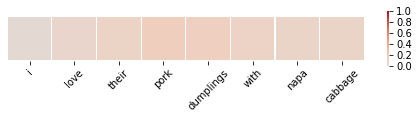

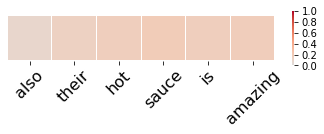

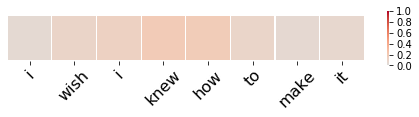

In [20]:
import seaborn as sn
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def sentiment_analysis(review):        
    tokenized_sentences = doc2hierarchical(review)
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        

sentiment_analysis("I love their pork dumplings with napa cabbage. Also, their hot sauce is amazing. I wish I knew how to make it!")

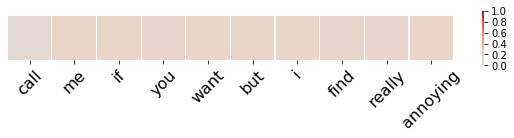

In [21]:
import seaborn as sn
from matplotlib import pyplot as plt

word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def sentiment_analysis(review):        
    tokenized_sentences = doc2hierarchical(review)
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        
sentiment_analysis("RT @lahellraiser call me sexist if you want, but I find female sportscasters really annoying.")

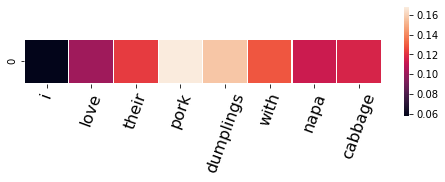

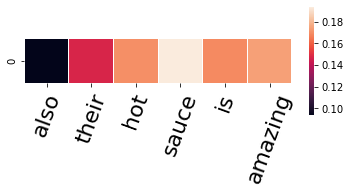

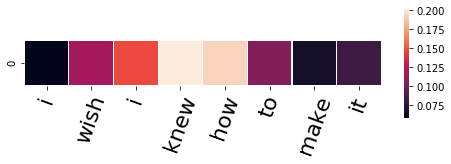

In [22]:
word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def sentiment_analysis(review):    
    sentences = sent_tokenize(review)
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=MAX_SENTENCE_LENGTH)
    pad_size = MAX_SENTENCES - tokenized_sentences.shape[0]

    if pad_size <= 0:
        tokenized_sentences = tokenized_sentences[:MAX_SENTENCES]
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0]
    for i, sentence in enumerate(tokenized_sentences[:-pad_size]):
        words = [word_rev_index[word_id] for word_id in sentence if word_id != 0][:50]
        pred_att = np.asarray(pred_attention[0][i][::-1][:len(words)][::-1])
        pred_att = np.expand_dims(pred_att, axis=0)

        fig, ax = plt.subplots(figsize=(len(words), 2))
        plt.rc('xtick', labelsize=22)
        heatmap = sn.heatmap(pred_att, xticklabels=words, square=True, linewidths=0.1)
        plt.xticks(rotation=70)
        plt.show()
sentiment_analysis("I love their pork dumplings with napa cabbage. Also, their hot sauce is amazing. I wish I knew how to make it!")